In [1]:
from os import environ

environ['optimizer'] = 'Adam'
environ['num_workers']= '2'
environ['batch_size']= '8192'
environ['n_epochs']= '1500'
environ['batch_norm']= 'True'
environ['loss_func']='MAPE'
environ['layers'] = '600 350 200 180'
environ['dropouts'] = '0.3 '*4
environ['log'] = 'False'
environ['weight_decay'] = '0.01'
environ['cuda_device'] ='cuda:0'
environ['dataset'] = '/data/scratch/mmerouani/data/speedup_dataset_research_batch1001-2000.pkl'

%run utils.ipynb

In [2]:
print("loading data")

train_dl, val_dl, test_dl = train_dev_split(dataset,val_size=10000, test_size=10000, batch_size=batch_size, num_workers=num_workers, log=log)
# train_dl, val_dl, test_dl = train_dev_split_filter(dataset,val_size=10000, test_size=10000, batch_size=batch_size, num_workers=num_workers, log=log, speedup_lo_bound=0.2)
db = fai.basic_data.DataBunch(train_dl, val_dl, test_dl, device=device)

print("data loaded")
print(val_dl.dataset.X.shape)

loading data


100%|██████████| 305800/305800 [08:44<00:00, 583.33it/s] 


data loaded
(305800, 3592)


In [3]:
input_size = train_dl.dataset.X.shape[1]
output_size = train_dl.dataset.Y.shape[1]

model = None 

if batch_norm:
    model = Model_BN_Tanh(input_size, output_size, hidden_sizes=layers_sizes, drops=drops)
else:
    model = Model(input_size, output_size)

# model = nn.DataParallel(model)
# model.to(device)

if loss_func == 'MSE':
    criterion = nn.MSELoss()
else:
    criterion = mape_criterion

l = fai.basic_train.Learner(db, model, loss_func=criterion, metrics=[mape_criterion, rmse_criterion],
                            callback_fns=[partial(EarlyStoppingCallback, mode='min', 
                            monitor='mape_criterion', min_delta=0, patience=150)],silent=True)

if optimizer == 'SGD':
    l.opt_func = optim.SGD 
    

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


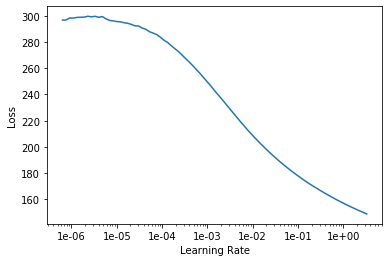

In [4]:
l.lr_find()
l.recorder.plot()

In [5]:
lr = 1e-02

In [6]:
l.fit_one_cycle(1500, lr)

Epoch 1375: early stopping


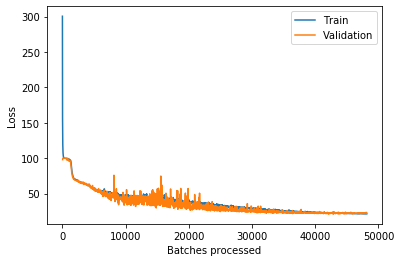

In [7]:
l.recorder.plot_losses()

In [ ]:
l.save(f"speedup_{optimizer}_batch_norm_{batch_norm}_{loss_func}_nlayers_{len(layers_sizes)}_log_{log}_batch1001-2000_Tanh")

In [8]:
val_df = get_results_df(val_dl, l.model)
train_df = get_results_df(train_dl, l.model)
test_df = get_results_df(test_dl, l.model)

In [9]:
test_df.describe()

,index,prediction,target,abs_diff,APE,SMAPE,interchange,tile,unroll
count,10000.00000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4999.50000,0.394191,0.438427,8.568693e-02,26.503281,29.168121,0.757900,0.940400,0.750000
std,2886.89568,0.337495,0.384616,1.351669e-01,31.023388,35.832699,0.428376,0.236756,0.433034
min,0.00000,0.000000,0.004559,1.341105e-07,0.000069,0.000069,0.000000,0.000000,0.000000
25%,2499.75000,0.083929,0.086719,1.185125e-02,6.467367,6.493939,1.000000,1.000000,0.750000
50%,4999.50000,0.273976,0.309265,3.979424e-02,15.677621,15.987193,1.000000,1.000000,1.000000
75%,7499.25000,0.725162,0.775881,1.058810e-01,35.185925,37.432458,1.000000,1.000000,1.000000
max,9999.00000,0.995968,2.645030,1.661787e+00,337.824738,200.000015,1.000000,1.000000,1.000000


In [10]:
val_df.describe()

,index,prediction,target,abs_diff,APE,SMAPE,interchange,tile,unroll
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,14999.50000,0.390927,0.434748,0.089760,22.783415,26.247038,0.782900,0.947300,0.750000
std,2886.89568,0.328884,0.526266,0.371606,28.276480,37.316029,0.412292,0.223445,0.433034
min,10000.00000,0.000000,0.004063,0.000002,0.001350,0.001350,0.000000,0.000000,0.000000
25%,12499.75000,0.079395,0.088260,0.009581,5.546226,5.550054,1.000000,1.000000,0.750000
50%,14999.50000,0.309840,0.323237,0.032796,13.120615,13.334513,1.000000,1.000000,1.000000
75%,17499.25000,0.688677,0.683457,0.081927,28.336584,28.041982,1.000000,1.000000,1.000000
max,19999.00000,0.997759,6.865816,5.873831,368.158966,200.000015,1.000000,1.000000,1.000000


In [11]:
train_df.describe()

,index,prediction,target,abs_diff,APE,SMAPE,interchange,tile,unroll
count,285800.000000,285800.000000,285800.000000,285800.000000,285800.000000,285800.000000,285800.000000,285800.000000,285800.000000
mean,162899.500000,0.393799,0.414619,0.050819,13.886036,16.100962,0.768034,0.944097,0.750000
std,82503.497805,0.329845,0.446321,0.277433,16.936615,26.703373,0.422088,0.229734,0.433013
min,20000.000000,0.000000,0.002826,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,91449.750000,0.085116,0.089102,0.006253,3.846730,3.856774,1.000000,1.000000,0.750000
50%,162899.500000,0.306052,0.313525,0.019789,8.693050,8.750660,1.000000,1.000000,1.000000
75%,234349.250000,0.700192,0.700698,0.052250,17.140782,17.573806,1.000000,1.000000,1.000000
max,305799.000000,0.999007,26.579260,25.600668,336.051819,200.000015,1.000000,1.000000,1.000000


In [12]:
gdf_t=pd.DataFrame(train_df.groupby(['name']).mean())
gdf_v=pd.DataFrame(val_df.groupby(['name']).mean())

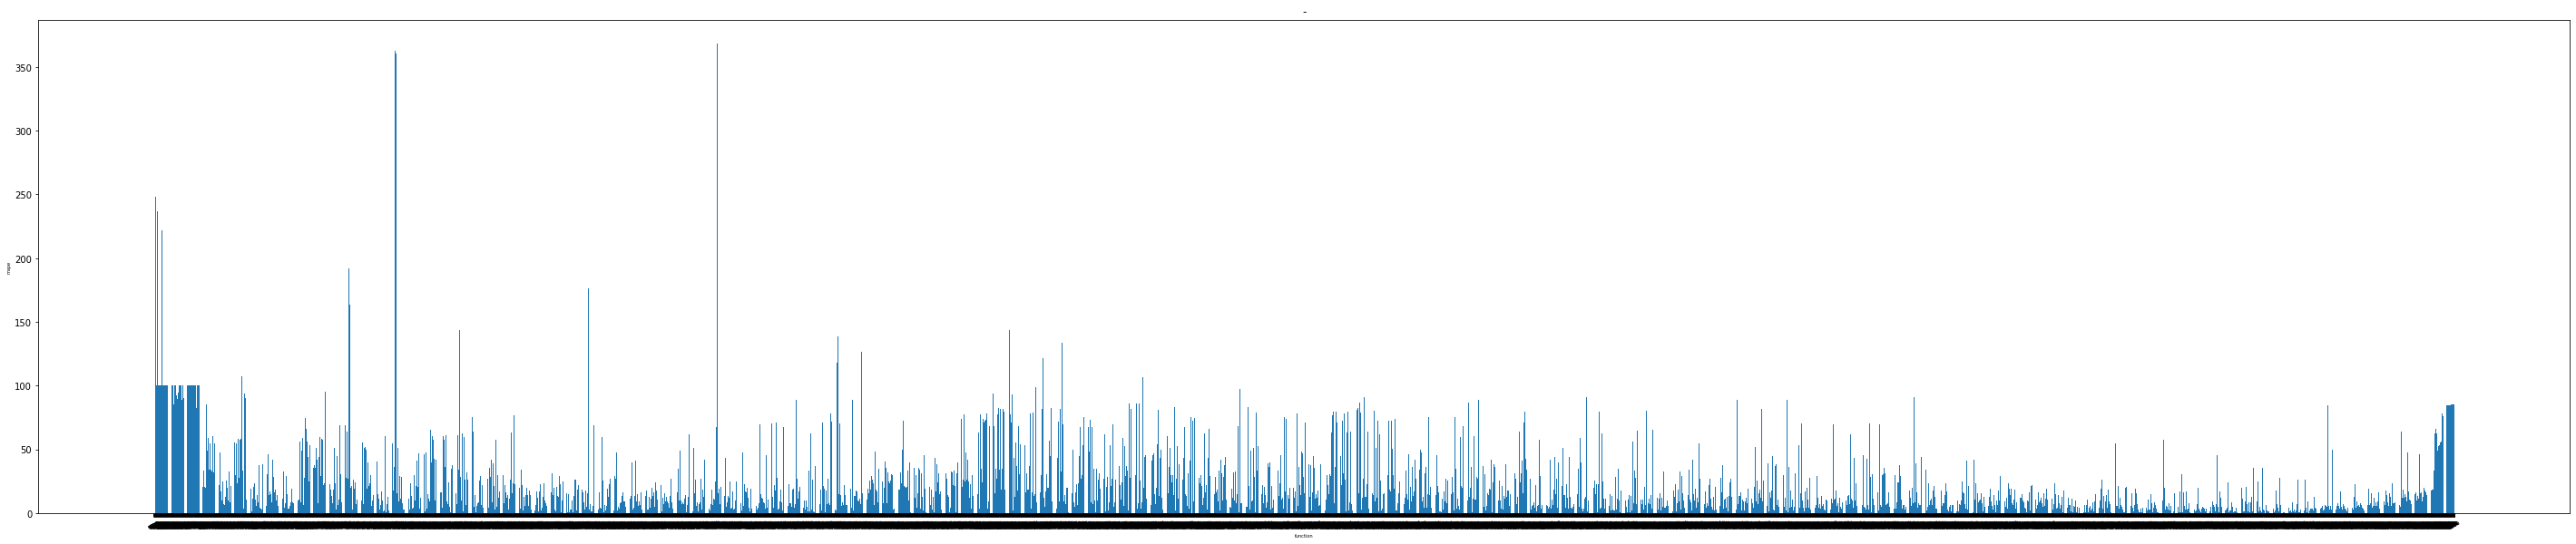

In [13]:
sorted_df=val_df.sort_values(by=["target"])
label=list(sorted_df.index)
mape=sorted_df['APE']
index = np.arange(len(label))
plt.figure(figsize=(50,10))
plt.bar(index, mape)
plt.xlabel('function', fontsize=5)
plt.ylabel('mape', fontsize=5)
plt.xticks(index, label, fontsize=5, rotation=30)
plt.title('-')
plt.show()

In [ ]:
sorted_df=gdf_t.sort_values(by=["target"])
label=list(sorted_df.index)
mape=sorted_df['APE']
index = np.arange(len(label))
plt.figure(figsize=(50,10))
plt.bar(index, mape)
plt.xlabel('function', fontsize=5)
plt.ylabel('mape', fontsize=5)
plt.xticks(index, label, fontsize=5, rotation=30)
plt.title('-')
plt.show()

In [14]:
df = val_df
df[(df.interchange==0) & (df.unroll == 0) & (df.tile == 0)][['prediction','target', 'abs_diff','APE']].describe()

,prediction,target,abs_diff,APE
count,32.000000,32.0,32.000000,32.000000
mean,0.937293,1.0,0.062707,6.270669
std,0.137371,0.0,0.137371,13.737098
min,0.188108,1.0,0.012252,1.225227
25%,0.951671,1.0,0.029568,2.956811
50%,0.962544,1.0,0.037456,3.745565
75%,0.970432,1.0,0.048329,4.832852
max,0.987748,1.0,0.811892,81.189194


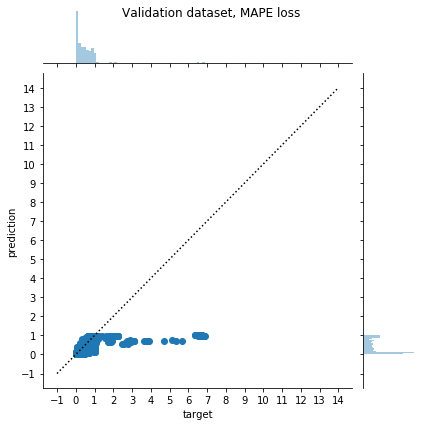

In [15]:
df1 = df[(df.interchange==0) & (df.unroll == 0) & (df.tile == 0)]
#joint_plot(df1, f"Validation dataset, {loss_func} loss")
df2 = df
joint_plot(df2, f"Validation dataset, {loss_func} loss")

In [16]:
df_ = val_df.sort_values(by=["APE"])

df_['x'] = range(len(df_))

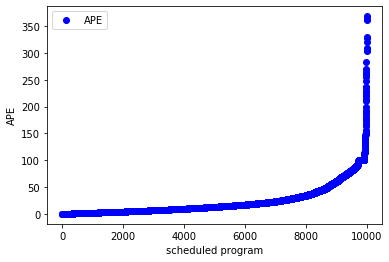

In [17]:
plt.plot('x', 'APE', 'bo', data=df_)


plt.xlabel('scheduled program')
plt.ylabel('APE')
plt.legend()

In [ ]:
l = l.load(f"speedup_{optimizer}_batch_norm_{batch_norm}_{loss_func}_nlayers_{len(layers_sizes)}_log_{log}_batch1001-2000_Tanh")